#import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load the datasets

In [3]:
df = pd.read_csv("data.csv",encoding='latin-1')

#**data** **preprocessing**

# Data cleaning function

In [4]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [5]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=fb3e0d1ef2a400b10a4aeced28018f21f129327fd507b6df19e457a4b57e2ca8
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


# Apply the 'clean_text' function to the 'clean_text' column using swifter for parallelized processing

In [6]:
import swifter

df['clean_text'] = df['title'] + " " + df['text']
df['clean_text'] = df['clean_text'].swifter.apply(clean_text)


Pandas Apply:   0%|          | 0/39942 [00:00<?, ?it/s]

# Split into train & test


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

## Convert text into TF-IDF features

In [8]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#**Modeling**

# Train SVM classifier

In [9]:
svm_model = SVC(kernel="linear", C=1.0)
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

# Predictions SVM

In [10]:
y_pred_svm = svm_model.predict(X_test_tfidf)

# Convert TF-IDF sparse matrix to dense for XGBoost

In [12]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Train XGBoost classifier

In [13]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=100, max_depth=6)
xgb_model.fit(X_train_dense, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Predictions

In [14]:
y_pred_xgb = xgb_model.predict(X_test_dense)

#RandomForest

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)


#LogisticRegression

In [16]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

# Load validation dataset


In [17]:
validation_df = pd.read_csv("validation_data.csv")

#Text cleaning

In [18]:
validation_df['clean_text'] = validation_df['title'] + " " + validation_df['text']
validation_df['clean_text'] = validation_df['clean_text'].apply(clean_text)

## Transform using TF-IDF

In [19]:
X_validation_tfidf = vectorizer.transform(validation_df['clean_text'])


# Predict using model all model

In [21]:
for model, name in zip([svm_model, xgb_model, rf_model, lr_model], ["svm", "xgb", "rf", "lr"]):
    y_pred_validation = model.predict(X_validation_tfidf)
    validation_df['label'] = y_pred_validation
    validation_df.to_csv(f"predicted_validation_data_{name}.csv", index=False)
    print(f"{name.upper()} Predictions saved successfully!")


SVM Predictions saved successfully!
XGB Predictions saved successfully!
RF Predictions saved successfully!
LR Predictions saved successfully!


# Model performance metrics

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score

models = {"SVM": y_pred_svm, "XGBoost": y_pred_xgb, "RandomForest": y_pred_rf, "Logistic Regression": y_pred_lr}
accuracies = [accuracy_score(y_test, y_pred) for y_pred in models.values()]
recalls = [recall_score(y_test, y_pred) for y_pred in models.values()]
f1_scores = [f1_score(y_test, y_pred) for y_pred in models.values()]

# Confusion matrices and classification reports

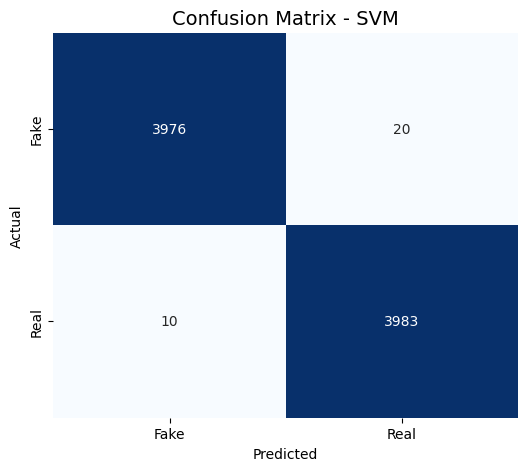

Classification Report for SVM
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3996
           1       1.00      1.00      1.00      3993

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



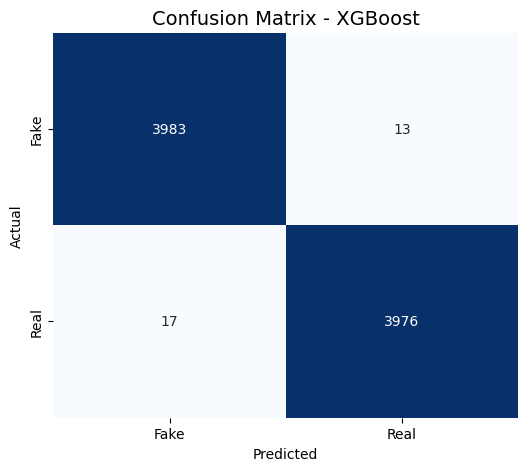

Classification Report for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3996
           1       1.00      1.00      1.00      3993

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



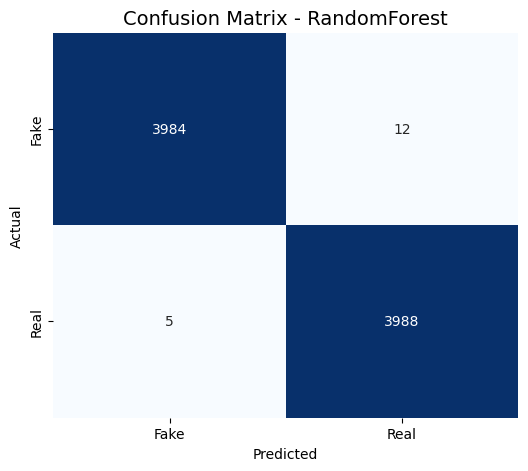

Classification Report for RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3996
           1       1.00      1.00      1.00      3993

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



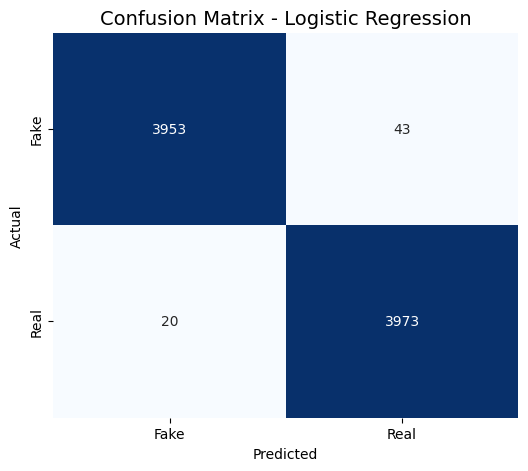

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3996
           1       0.99      0.99      0.99      3993

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989



In [25]:
for name, y_pred in models.items():
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title(f"Confusion Matrix - {name}", fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"Classification Report for {name}")
    print(classification_report(y_test, y_pred))


#Chart

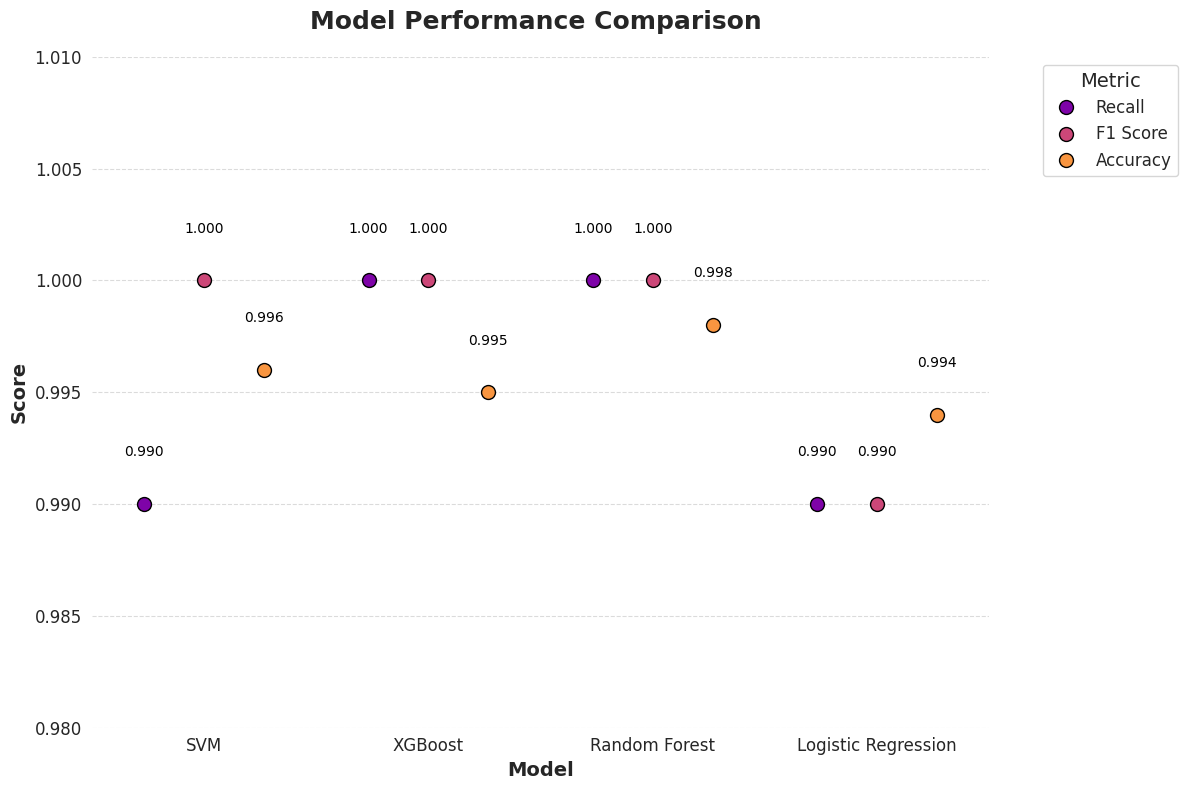

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
data = {
    "Model": ["SVM", "XGBoost", "Random Forest", "Logistic Regression"],
    "Recall": [0.99, 1.0, 1.0, 0.99],
    "F1 Score": [1.0, 1.0, 1.0, 0.99],
    "Accuracy": [0.996, 0.995, 0.998, 0.994],
}

# Create DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars=["Model"], var_name="Metric", value_name="Score")

# Set a modern style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create the organized dot plot using swarmplot
ax = sns.swarmplot(
    x="Model",
    y="Score",
    hue="Metric",
    data=df_melted,
    palette="plasma",  # Use a vibrant color palette
    size=10,          # Dot size
    dodge=True,       # Separate dots for different metrics
    edgecolor="black", # Add black edges to dots
    linewidth=1       # Edge thickness
)

# Add annotations (values on top of dots)
# Get the positions of the dots
dots = ax.collections

# Loop through each dot and add annotations
for dot in dots:
    paths = dot.get_offsets()  # Get the positions of the dots
    for x, y in paths:
        ax.text(x, y + 0.002, f"{y:.3f}", ha="center", va="bottom", fontsize=10, color="black")

# Customize the plot
plt.title("Model Performance Comparison ", fontsize=18, fontweight="bold", pad=20)
plt.ylim(0.98, 1.01)  # Adjust y-axis limits for better visualization
plt.ylabel("Score", fontsize=14, fontweight="bold")
plt.xlabel("Model", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Move the legend outside the plot
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle="--", alpha=0.7)

# Remove spines (borders) for a cleaner look
sns.despine(left=True, bottom=True)

# Show plot
plt.tight_layout()
plt.show()

#Text Chart

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-39-5ec15e68685d>:70: UserWarning: Glyph 8204 (\N{ZERO WIDTH NON-JOINER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


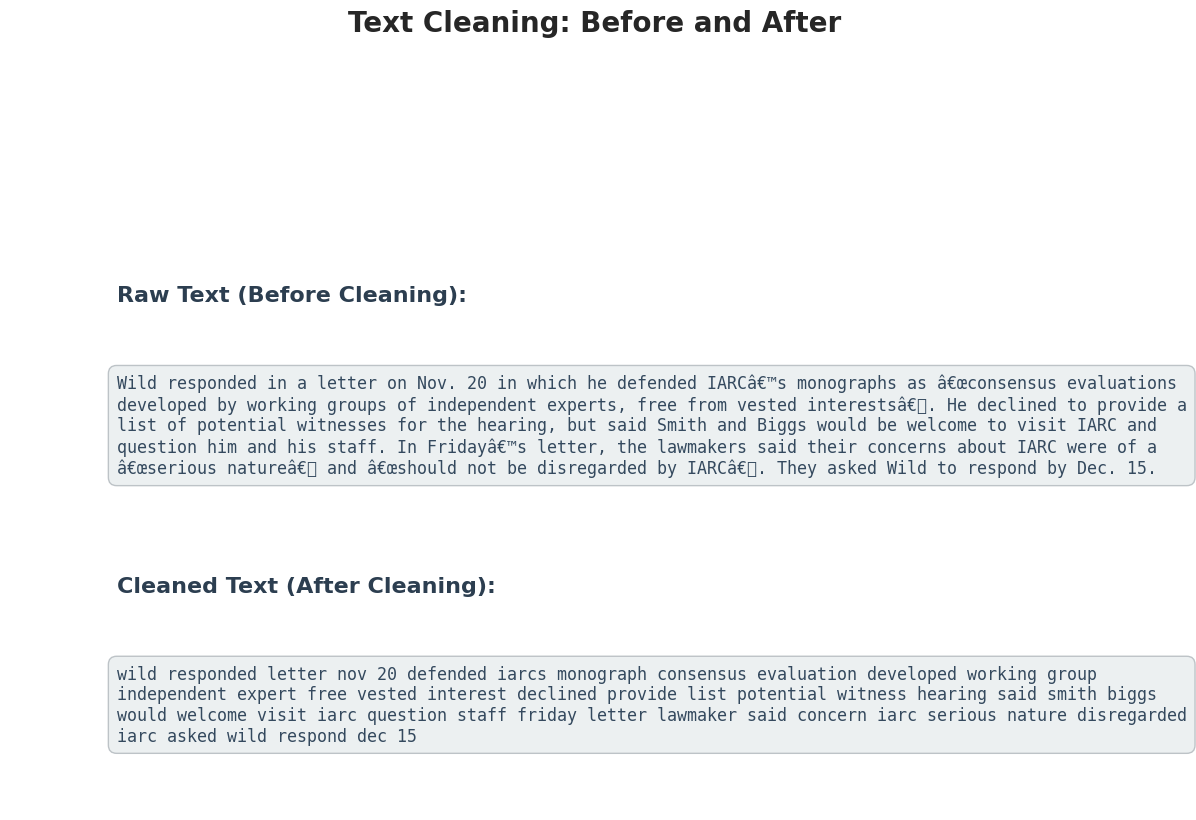

In [39]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Define the cleaning function
def clean_text(text):
    # Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and symbols
    text = re.sub(r'\W', ' ', text)

    # Replace multiple spaces with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Split text into words
    words = text.split()

    # Remove stopwords and lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]

    # Join words back into a single string
    return ' '.join(words)

# Example text
raw_text = (
    "Wild responded in a letter on Nov. 20 in which he defended IARCâ€™s monographs as â€œconsensus evaluations "
    "developed by working groups of independent experts, free from vested interestsâ€‌. He declined to provide a list "
    "of potential witnesses for the hearing, but said Smith and Biggs would be welcome to visit IARC and question him "
    "and his staff. In Fridayâ€™s letter, the lawmakers said their concerns about IARC were of a â€œserious natureâ€‌ "
    "and â€œshould not be disregarded by IARCâ€‌. They asked Wild to respond by Dec. 15."
)

# Clean the text
cleaned_text = clean_text(raw_text)

# Create a beautiful visual representation
plt.figure(figsize=(12, 8))

# Add a title
plt.suptitle("Text Cleaning: Before and After", fontsize=20, fontweight="bold", y=1.02)

# Add a background color
plt.gca().set_facecolor('#f7f7f7')

# Display raw text
plt.text(0.1, 0.7, "Raw Text (Before Cleaning):", fontsize=16, fontweight="bold", color='#2c3e50', fontfamily='sans-serif')
plt.text(0.1, 0.6, raw_text, fontsize=12, wrap=True, va="top", color='#34495e', fontfamily='monospace', bbox=dict(facecolor='#ecf0f1', edgecolor='#bdc3c7', boxstyle='round,pad=0.5'))

# Display cleaned text
plt.text(0.1, 0.3, "Cleaned Text (After Cleaning):", fontsize=16, fontweight="bold", color='#2c3e50', fontfamily='sans-serif')
plt.text(0.1, 0.2, cleaned_text, fontsize=12, wrap=True, va="top", color='#34495e', fontfamily='monospace', bbox=dict(facecolor='#ecf0f1', edgecolor='#bdc3c7', boxstyle='round,pad=0.5'))

# Remove axes
plt.axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()